## Workflow to analyze Photometry data

### Imports

In [73]:
# allow for automatic reloading of classes and function when updating the code
%load_ext autoreload
%autoreload 2 

# Import Session and Experiment class with helper functions
from trialexp.process.data_import import *


### Variables

In [74]:
import pandas as pd

trial_window = [-2000, 6000] # in ms

# time limit around trigger to perform an event
# determine successful trials
timelim = [0, 2000] # in ms

# Digital channel nb of the pyphotometry device
# on which rsync signal is sent (from pycontrol device)
rsync_chan = 2

basefolder, _ = os.path.split(os.getcwd())

# These must be absolute paths
# use this to use within package tasks files (in params)
tasksfile = os.path.join(basefolder,'params/tasks_params.csv')
# use this to put a local full path
#tasksfile = -r'C:/.../tasks_params.csv' 

photometry_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\test_folder\photometry'
video_dir = r'\\ettin\Magill_Lab\Julien\Data\head-fixed\videos'

In [75]:
# Folder of a full experimental batch, all animals included

# Enter absolute path like this
pycontrol_files_path = r'T:\Data\head-fixed\test_folder\pycontrol'

# or this if you want to use data from the sample_data folder within the package
#pycontrol_files_path = os.path.join(basefolder,'sample_data/pycontrol')

# Load all raw text sessions in the indicated folder or a sessions.pkl file
# if already existing in folder_path
exp_cohort = Experiment(pycontrol_files_path)



Saved sessions loaded from: sessions.pkl


In [76]:
# Find if there is a matching photometry file and if it can be used:
# rsync synchronization pulses matching between behaviour and photometry
exp_cohort.match_to_photometry_files(photometry_dir, rsync_chan, verbose=False)

# Find matching videos
exp_cohort.match_sessions_to_files(video_dir, ext='mp4')

# FInd matching DeepLabCut outputs files
exp_cohort.match_sessions_to_files(video_dir, ext='h5')

exp_cohort.save()


c:\users\phar0732\documents\github\trialexp\trialexp\utils\rsync.py:78: RuntimeWarning: invalid value encountered in log
  log_mse = np.log(chunk_mse)
c:\Users\phar0732\.conda\envs\trialexp\lib\site-packages\sklearn\mixture\_base.py:131: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  cluster.KMeans(
c:\users\phar0732\documents\github\trialexp\trialexp\utils\rsync.py:100: RuntimeWarning: All-NaN slice encountered
  order_OK = ((np.nanmin(np.diff(cor_times_A)) > 0) and
c:\users\phar0732\documents\github\trialexp\trialexp\utils\pycontrol_utilities.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match_df['timedelta'] = match_df['datetime'].apply(lambda x: abs(dateti

Print valid photometry path of sessions

In [ ]:
for s in range(0,len(exp_cohort.sessions)):
    if exp_cohort.sessions[s].photometry_path is not None:
        print(exp_cohort.sessions[s].photometry_path)

Select a subset of sessions, here based on the task name and having a valid photometry file

In [77]:
exp_cohort.sessions = [session for session in exp_cohort.sessions if (
    session.task_name == 'reaching_go_nogo') and (session.photometry_path is not None)]

len(exp_cohort.sessions)

108

Perform analysis by trial only on this subset

In [78]:
# Process the whole experimental folder by trials
exp_cohort.process_exp_by_trial(trial_window, timelim, tasksfile, blank_spurious_event='spout', blank_timelim=[0, 65])

# Save the file as sessions.pkl in folder_path
exp_cohort.save()

No event  'spout'  found:  295 2022-01-12 17:15:29 reaching_go_nogo


Select the subset of sessions for one animal which have photometry trials

In [608]:
sessions_subset = [session for session in exp_cohort.sessions if (
    session.task_name == 'reaching_go_nogo') 
    and (session.photometry_path is not None)
    and (session.subject_ID == 297)]


Processing tests

In [651]:
idx = 5
low_pass = 45
high_pass = 0.05
median_filt = 3
motion_corr = True
df_over_f = True
downsampling_factor = None
export_vars = ['analog_1','analog_2','analog_1_filt','analog_2_filt','analog_1_est_motion','analog_1_corrected','analog_1_corrected']

df_meta_photo, col_names_numpy, photo_array, photometry_dict = sessions_subset[idx].get_photometry_trials(
    conditions_list = None, 
    cond_aliases = None,
    trig_on_ev = None, 
    high_pass = high_pass, 
    low_pass = low_pass, 
    median_filt = median_filt, 
    motion_corr = motion_corr, 
    df_over_f = df_over_f, 
    downsampling_factor = downsampling_factor,
    return_full_session = True, 
    export_vars = export_vars,
    verbose = True)

try:
    rig_nb = int(sessions_subset[idx].files['mp4'][0].split('Rig_')[1][0])
except:
    rig_nb = 'unknown'

print(sessions_subset[idx].subject_ID, sessions_subset[idx].datetime, ' rig:', rig_nb)


condition 0 trials: 202
297 2022-03-15 12:50:39  rig: 1


Plotting raw signals

In [652]:
import pylab as plt
plt.rcParams['figure.figsize'] = [10, 6] # Make default figure size larger.
plt.rcParams['axes.xmargin'] = 0          # Make default margin on x axis zero.

In [653]:
from scipy.optimize import curve_fit
# The exponential curve we are going to fit.
def exp_func(x, a, b, c):
   return a*np.exp(-b*x) + c

time = np.linspace(1/1000, len(photometry_dict['analog_1'])/1000, len(photometry_dict['analog_1']))

# ana_1_params, parm_cov = curve_fit(exp_func, time, medfilt(photometry_dict['analog_1'],3), p0=[1,1e-3,1],bounds=([0,0,0],[4,0.1,4]), maxfev=1000)
# photometry_dict['analog_1_expfit'] = exp_func(time, *ana_1_params)

ana_2_params, parm_cov = curve_fit(exp_func, time, medfilt(photometry_dict['analog_2'],3), p0=[1,1e-3,1],bounds=([0,0,0],[4,0.1,4]), maxfev=1000)
photometry_dict['analog_2_expfit'] = exp_func(time, *ana_2_params)

In [654]:
xlim = [480,800] # [2475,2505]#[0,3500] # [2340,2350]
ylim = [0.10, 0.35]

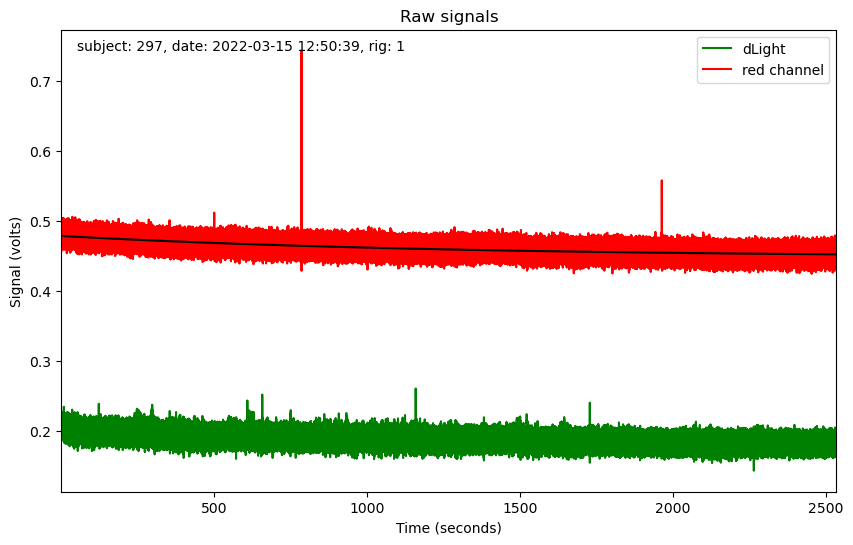

In [655]:
fig, ax = plt.subplots()

plt.plot(time, photometry_dict['analog_1'], 'g', label='dLight')
plt.plot(time, photometry_dict['analog_2'], 'r', label='red channel')
# plt.plot(time, photometry_dict['analog_1_expfit'], 'k')
plt.plot(time, photometry_dict['analog_2_expfit'], 'k')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Raw signals')
ax.text(0.02, 0.98, f'subject: {sessions_subset[idx].subject_ID}, date: {sessions_subset[idx].datetime}, rig: {rig_nb}',
        ha='left', va='top', transform=ax.transAxes)
# plt.xlim(xlim)
# plt.ylim(ylim)
plt.legend();

The data will be the signal on the control channel minus its exponential fit.  
Artifacted periods, if they exist, are expected to create a lower gaussian distribution, whereas the main distribution will be at higher red channel values (no shadow)

In [656]:
data = medfilt(photometry_dict['analog_2'],3) - photometry_dict['analog_2_expfit']
# data = medfilt(photometry_dict['analog_2'],3)

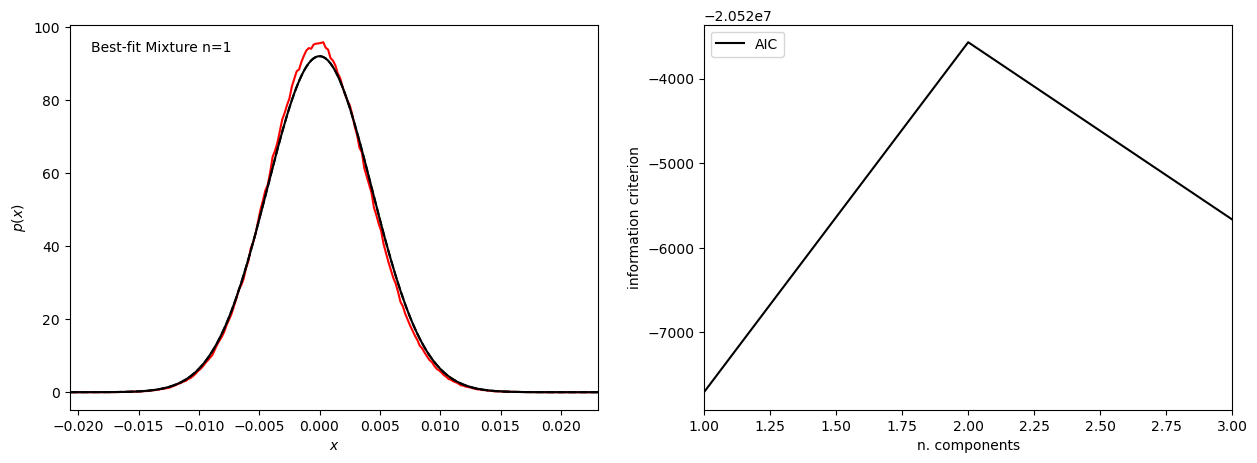

In [657]:
# Original author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from matplotlib import pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

#------------------------------------------------------------
# Set up the dataset. 

X = data.reshape(-1, 1)

# (original code: We'll create our dataset by drawing samples from Gaussians)
# random_state = np.random.RandomState(seed=1)

# X = np.concatenate([random_state.normal(-1, 1.5, 350),
#                     random_state.normal(0, 1, 500),
#                     random_state.normal(3, 0.5, 150)]).reshape(-1, 1)

#------------------------------------------------------------
# Learn the best-fit GaussianMixture models
#  Here we'll use scikit-learn's GaussianMixture model. The fit() method
#  uses an Expectation-Maximization approach to find the best
#  mixture of Gaussians for the data

# fit models with 1-10 components
N = np.arange(1, 4)
models = [None for i in range(len(N))]

for i in range(len(N)):
    models[i] = GaussianMixture(N[i]).fit(X)

# compute the AIC and the BIC
AIC = [m.aic(X) for m in models]
# BIC = [m.bic(X) for m in models]

#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component

fig = plt.figure(figsize=(15, 5))
# fig.subplots_adjust(left=0.12, right=0.97,
#                     bottom=0.21, top=0.9, wspace=0.5)


# plot 1: data + best-fit mixture
ax = fig.add_subplot(121)

# Original part, take the min of AIC to determine how many gaussians
# M_best = models[np.argmin(AIC)]

# Customized part tweaked to reduce the nb of gaussian used to the minimum
diff_AIC = np.diff(AIC)
if diff_AIC[0] > 0:
    n_best = 0
else:
    n_best = np.where(diff_AIC == min(diff_AIC))[0][0]+1
    
M_best = models[n_best]
# end of customized part

p, bins = np.histogram(X, bins=np.arange(min(X),max(X),0.0002), density=True)

x = bins
logprob = M_best.score_samples(x.reshape(-1, 1))
# logprob = M_best.score_samples(x)

responsibilities = M_best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.plot(x[:-1], p, 'r') # approximation
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, f'Best-fit Mixture n={n_best+1}',
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(122)
ax.plot(N, AIC, '-k', label='AIC')
# ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)

plt.show()

In [658]:
M_best.means_

array([[-3.49073272e-11]])

In [659]:
M_best.covariances_

array([[[1.87809299e-05]]])

Only compute variance of red channel for all trials and fix arbitrary threshold

Text(0.5, 0, 'trials')

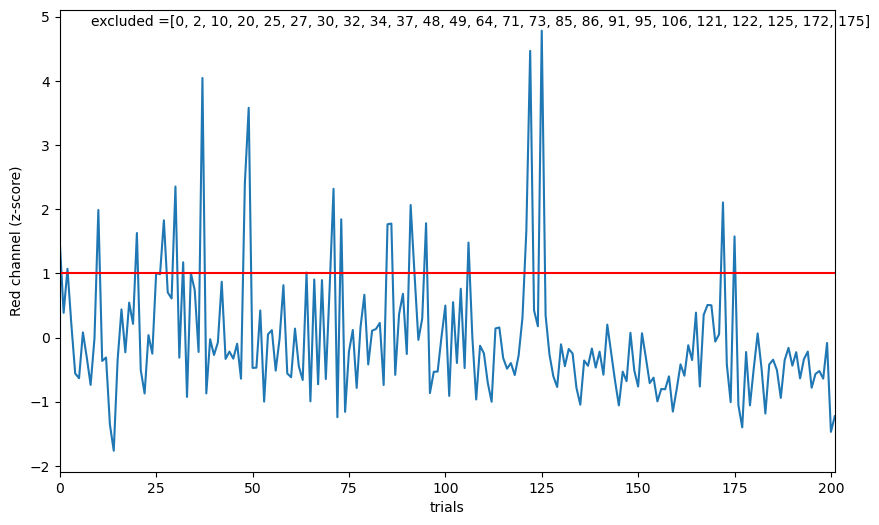

In [660]:
from scipy.stats import zscore

z_thresh = 1

fig, ax = plt.subplots()
var_trials = photo_array[:,col_names_numpy['analog_2_filt']].var(1)
zscore_var = zscore(var_trials)
trials_to_exclude = [idx for idx, v in enumerate(zscore_var) if v > z_thresh]
trials_to_include = [idx for idx, v in enumerate(zscore_var) if v < z_thresh]

# plt.plot(var_trials)
plt.plot(zscore_var)
plt.axhline(z_thresh,c='r')
plt.text(0.04, 0.96, f'excluded ={trials_to_exclude}',
        ha='left', va='bottom', transform=ax.transAxes)
plt.ylabel('Red channel (z-score)')
plt.xlabel('trials')

Plot excluded and included trials in filtered Red and Green channels

Text(0.5, 1.0, 'green channel included trials')

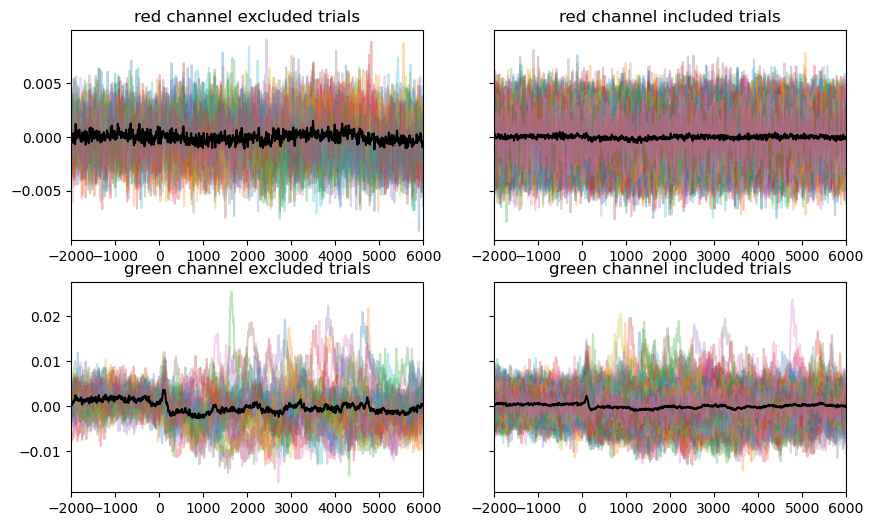

In [661]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharey='row')
timevec_trial = np.linspace(sessions_subset[idx].trial_window[0], sessions_subset[idx].trial_window[1], photo_array.shape[2])

_ = axs[0,0].plot(timevec_trial, photo_array[trials_to_exclude,col_names_numpy['analog_2_filt']].T, alpha=0.3)
_ = axs[0,0].plot(timevec_trial, photo_array[trials_to_exclude,col_names_numpy['analog_2_filt']].mean(0), c='k', alpha=1)

_ = axs[0,1].plot(timevec_trial, photo_array[trials_to_include,col_names_numpy['analog_2_filt']].T, alpha=0.3)
_ = axs[0,1].plot(timevec_trial, photo_array[trials_to_include,col_names_numpy['analog_2_filt']].mean(0), c='k', alpha=1)

_ = axs[1,0].plot(timevec_trial, photo_array[trials_to_exclude,col_names_numpy['analog_1_filt']].T, alpha=0.3)
_ = axs[1,0].plot(timevec_trial, photo_array[trials_to_exclude,col_names_numpy['analog_1_filt']].mean(0), c='k', alpha=1)
_ = axs[1,1].plot(timevec_trial, photo_array[trials_to_include,col_names_numpy['analog_1_filt']].T, alpha=0.3)
_ = axs[1,1].plot(timevec_trial, photo_array[trials_to_include,col_names_numpy['analog_1_filt']].mean(0), c='k', alpha=1)

axs[0,0].set_title('red channel excluded trials')
axs[0,1].set_title('red channel included trials')

axs[1,0].set_title('green channel excluded trials')
axs[1,1].set_title('green channel included trials')



In [430]:
photo_array[:,col_names_numpy['analog_2']].var()

7.856015475877363e-05

In [411]:
from numpy.lib.stride_tricks import sliding_window_view

v = sliding_window_view(data, 8000, 0)
print(data.shape, v.shape)

v[:,1].shape

(2215700,) (2207701, 8000)


(2207701,)

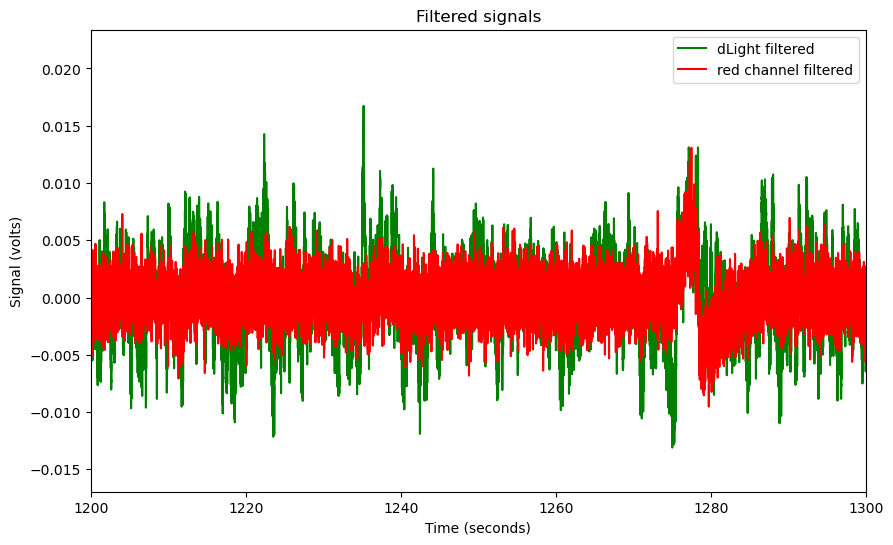

In [394]:
xlim = [1200,1300]
plt.plot(time, photometry_dict['analog_1_filt'], 'g', label='dLight filtered')
plt.plot(time, photometry_dict['analog_2_filt'], 'r', label='red channel filtered')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Filtered signals')

plt.xlim(xlim)
# plt.ylim(ylim)
plt.legend();

In [ ]:
#Gaussian least-square fitting process
param_optimised,param_covariance_matrix = curve_fit(gaus,x_hist,y_hist,p0=[max(y_hist),mean,sigma],maxfev=5000)

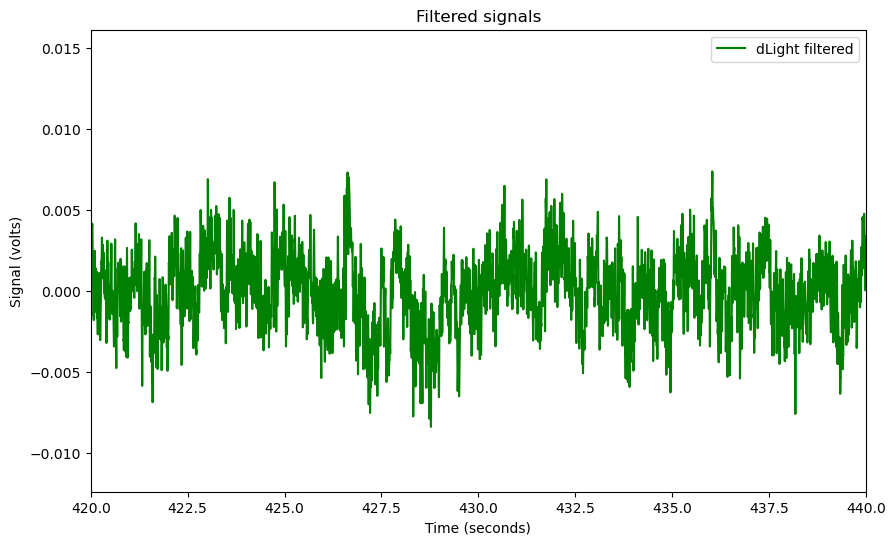

In [184]:

plt.plot(time, photometry_dict['analog_1_filt'], 'g', label='dLight filtered')
# plt.plot(time, photometry_dict['analog_2_filt'], 'r', label='red channel filtered')
plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Filtered signals')

plt.xlim(xlim)
# plt.ylim(ylim)
plt.legend();

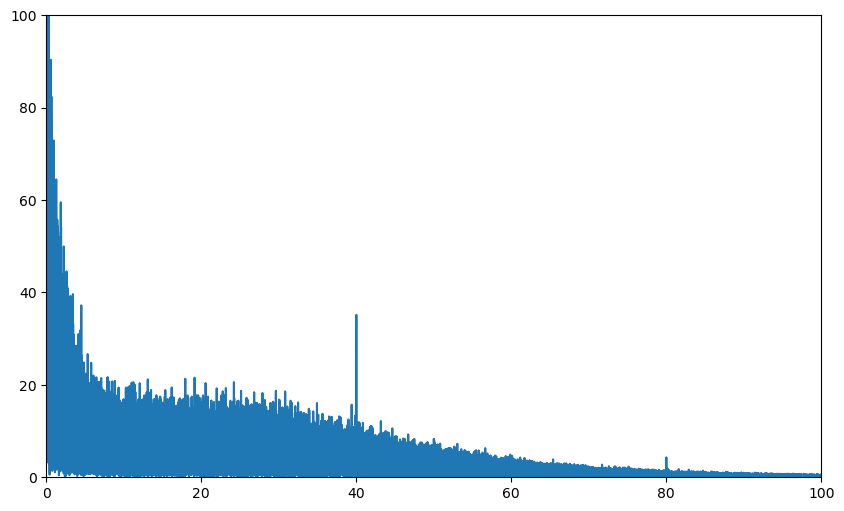

In [185]:
from scipy.fft import rfft, rfftfreq

spec = rfft(photometry_dict['analog_1_filt'])
freq = rfftfreq(len(photometry_dict['analog_1_filt']), 1 / photometry_dict['sampling_rate'])

plt.plot(freq, np.abs(spec))
plt.xlim([0,100])
plt.ylim([0,100])
plt.show()

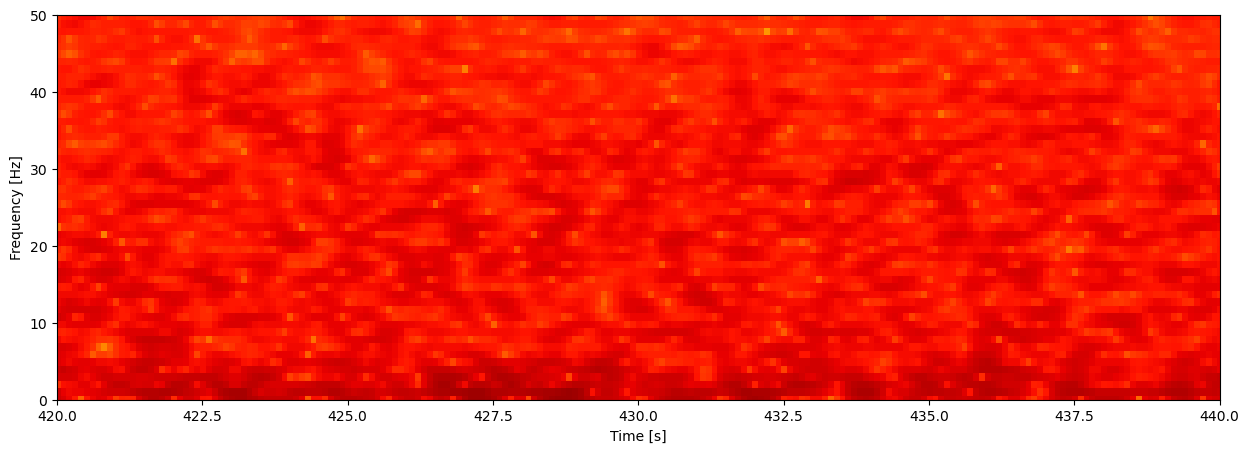

In [186]:
from scipy import signal
nperseg = 1024
noverlap = nperseg-100

freqs, times, Sx = signal.spectrogram(photometry_dict['analog_1_filt'], fs=photometry_dict['sampling_rate'], window='hanning',
                                      nperseg=nperseg, noverlap=noverlap,
                                      detrend=False, scaling='spectrum')

f, ax = plt.subplots(figsize=(15, 5))
ax.pcolormesh(times, freqs, 10 *  np.log10(Sx), cmap='jet')
ax.set_ylim([0, 50])
ax.set_xlim(xlim)
ax.set_ylabel('Frequency [Hz]')
ax.set_xlabel('Time [s]');

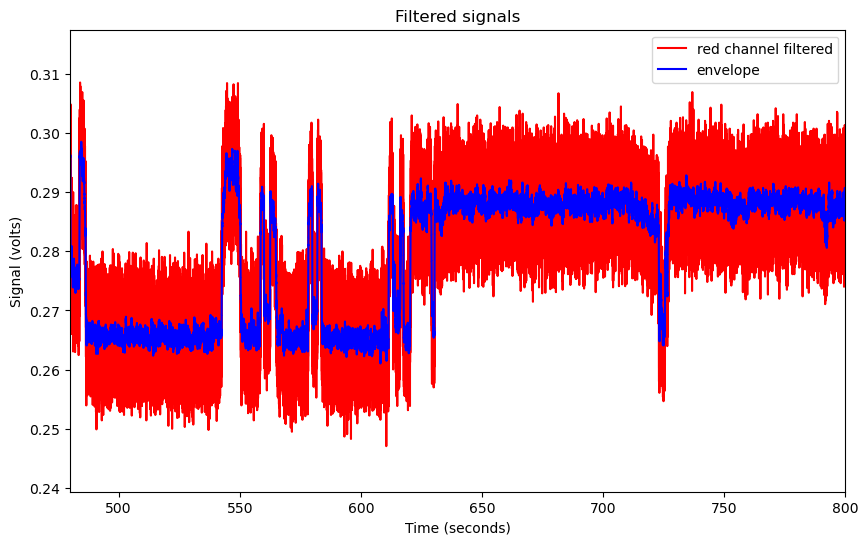

In [207]:
from scipy.stats import zscore
from scipy.signal import medfilt, hilbert

# z= hilbert(medfilt(photometry_dict['analog_2'],3)) #form the analytical signal
# inst_amplitude = np.abs(z) #envelope extraction
plt.plot(time, medfilt(photometry_dict['analog_2'],3), 'r', label='red channel filtered')
plt.plot(time, medfilt(photometry_dict['analog_2'],101), 'b', label='envelope')
# plt.plot(time, zscore(medfilt(photometry_dict['analog_2'],3)), 'orange', label='red channel filtered')


plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Filtered signals')

plt.xlim(xlim)
# plt.ylim(ylim)
plt.legend();

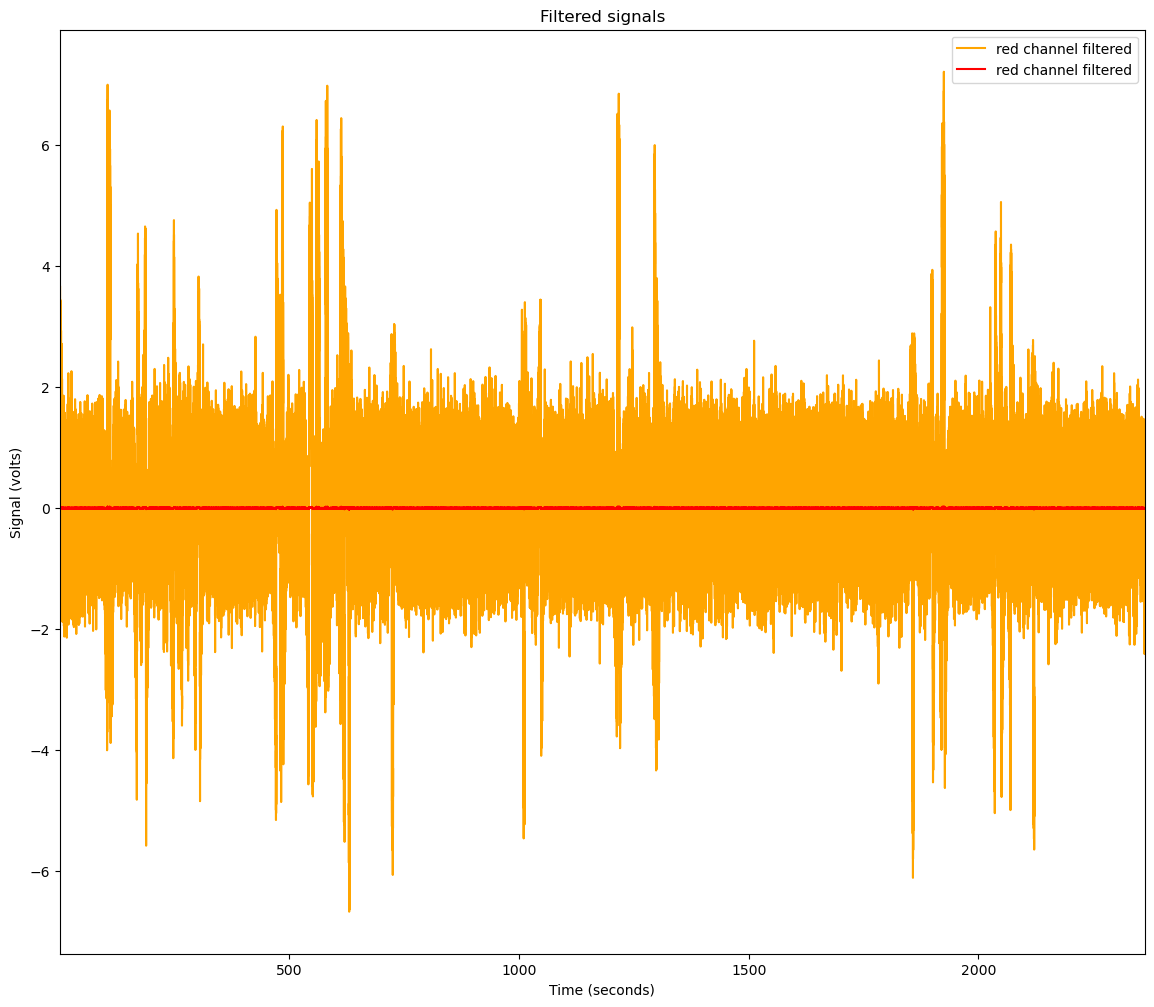

In [105]:
from scipy.stats import zscore
from scipy.signal import medfilt
xlim = [100,300]


plt.plot(time, zscore(photometry_dict['analog_2_filt']), 'orange', label='red channel filtered')
plt.plot(time, photometry_dict['analog_2_filt'], 'r', label='red channel filtered')


plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Filtered signals')

# plt.xlim(xlim)
# plt.ylim(ylim)
plt.legend();

In [461]:
# slope, intercept, r_value, p_value, std_err = linregress(x=TdTom_highpass, y=GCaMP_highpass)

# plt.scatter(TdTom_highpass[::5], GCaMP_highpass[::5],alpha=0.1, marker='.')
# x = np.array(plt.xlim())
# plt.plot(x, intercept+slope*x)
# plt.xlabel('TdTomato')
# plt.ylabel('GCaMP')
# plt.title('TdTomato - GCaMP correlation.')

# print('Slope    : {:.3f}'.format(slope))
# print('R-squared: {:.3f}'.format(r_value**2))

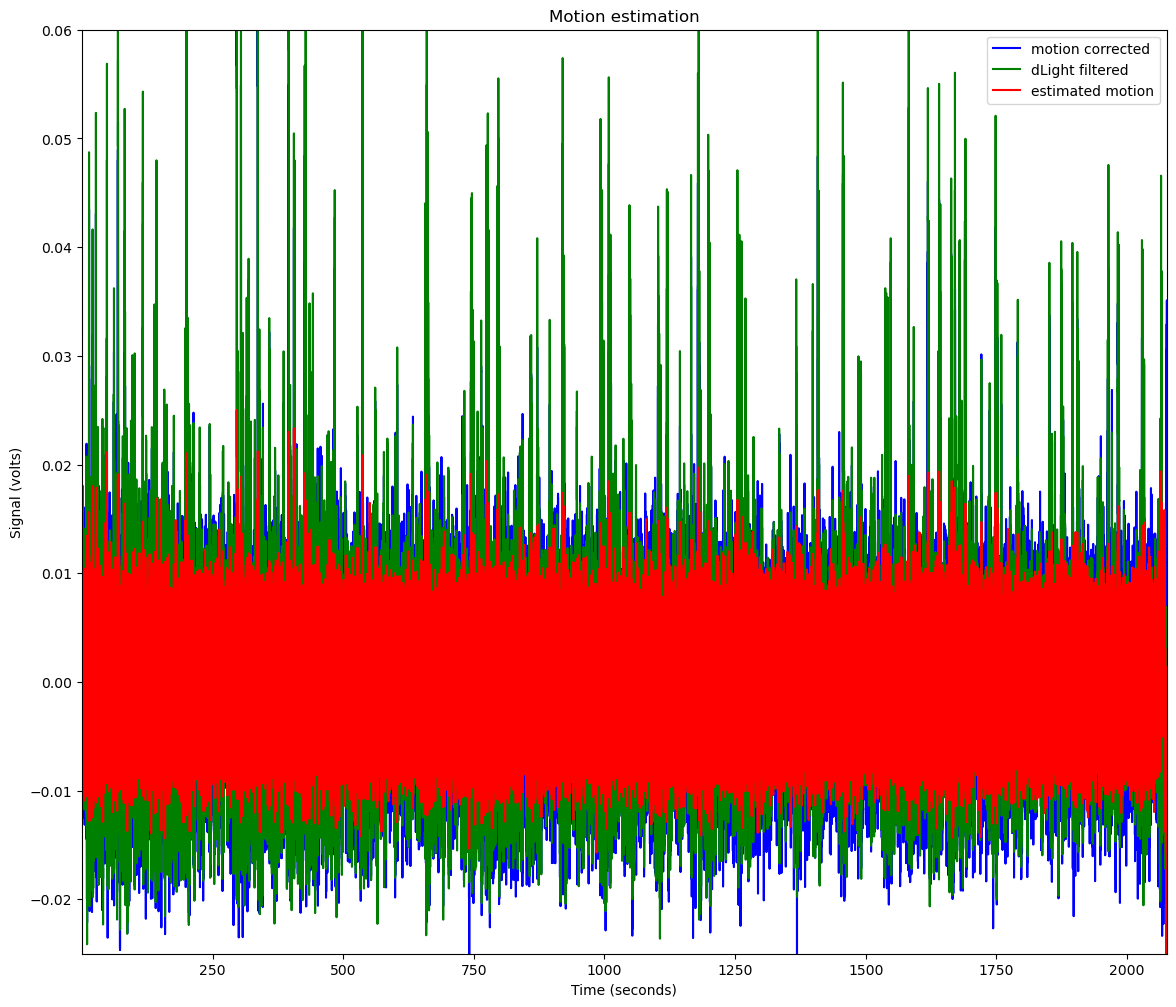

In [16]:
ylim = [-0.025, 0.06]

plt.plot(time, photometry_dict['analog_1_corrected'], 'b', label='motion corrected')
plt.plot(time, photometry_dict['analog_1_filt'], 'g', label='dLight filtered')
plt.plot(time, photometry_dict['analog_1_est_motion'], 'r', label='estimated motion')

plt.xlabel('Time (seconds)')
plt.ylabel('Signal (volts)')
plt.title('Motion estimation')

# plt.xlim(xlim)
plt.ylim(ylim)
plt.legend();

### Define conditions and groups for extraction

In [17]:
# Defime each trial type as a dictionary of conditions to be met
conditions_dict1 = {'trigger': 'CS_Go', 'valid': True, 'success': True, 'error bar_off': False, 'reward free': False, 'button_press': False}
conditions_dict2 = {'trigger': 'CS_Go', 'valid': True, 'success': False, 'reward free': False, 'button_press': False}
conditions_dict3 = {'trigger': 'CS_Go', 'valid': True, 'success': True, 'error bar_off': True, 'reward free': False, 'button_press': False}
conditions_dict4 = {'trigger': 'CS_NoGo', 'valid': True, 'success': True, 'button_press': False}
conditions_dict5 = {'trigger': 'CS_NoGo', 'valid': True, 'success': False, 'button_press': False}

# Aggregate all condition dictionaries in a list
condition_list = [conditions_dict1, conditions_dict2, conditions_dict3, conditions_dict4, conditions_dict5]
# Aliases for conditions
cond_aliases = ['Go hit', 'Go miss', 'Go hit error', 'NoGo hit', 'NoGo miss']
# Groups as a list of lists
groups = [[280, 281, 282, 289],[295, 282, 284, 285, 292, 297]]
# Window to exctract (in ms)
trial_window = [-2000, 6000]

### Extract Photometry trials and create a Continuous_Dataset

In [19]:
cont_dataset = exp_cohort.get_photometry_groups(
        groups = None, # or use groups variable defined above
        conditions_list = condition_list, 
        cond_aliases = cond_aliases, 
        when = 'all', 
        task_names = 'reaching_go_nogo', #'reaching_go_nogo',
        trig_on_ev = None, # align to the first event of a kind e.g. bar_off
        high_pass = 0.05, 
        low_pass = 45, 
        median_filt = 3,
        motion_corr = True, 
        df_over_f = True, 
        downsampling_factor = 5, 
        export_vars = ['analog_1','analog_1_filt','analog_2','analog_2_filt','analog_1_df_over_f', 'analog_1_est_motion', 'analog_1_corrected'],
        verbose = False)

cont_dataset.set_trial_window(trial_window, 'ms')


No trial in any condition for subject 289 at: 2022-01-13 11:29:37
No trial in any condition for subject 291 at: 2022-01-12 16:26:30
No trial in any condition for subject 294 at: 2022-01-19 13:28:59
No trial in any condition for subject 294 at: 2022-03-15 13:41:23
No trial in any condition for subject 295 at: 2022-01-12 17:15:29
No trial in any condition for subject 300 at: 2022-06-27 14:32:03
No trial in any condition for subject 301 at: 2022-06-07 16:13:08
No trial in any condition for subject 305 at: 2022-05-18 14:28:34
No trial in any condition for subject 306 at: 2022-05-30 12:54:56
No trial in any condition for subject 307 at: 2022-06-28 17:59:38


In [12]:
cont_dataset.conditions

[{'success': True}, {'success': False}]

### Save Photometry Dataset

In [20]:
folder_path = r'C:\Users\phar0732\Documents\GitHub\trialexp\outputs'
cont_dataset.save(folder_path, 'photo_reaching_gonogo_mf3_hp0.05_lp45')

Dataset saved in C:\Users\phar0732\Documents\GitHub\trialexp\outputs\photo_reaching_gonogo_mf3_hp0.05_lp45.pkl
data size is 956.0059967041016 Mb


### Reload a pre-existing dataset

In [21]:
dataset_full_path = r'C:\Users\phar0732\Documents\GitHub\trialexp\outputs\photo_reaching_gonogo_mf3_hp0.05_lp45.pkl'
cont_dataset = load_dataset(dataset_full_path)

Export to sktime (pandas panel format instead of numpy)

In [27]:
X, y = cont_dataset.export_to_sktime(folder = folder_path, name = 'sktime_gonogo')

Nested Dataframe saved in C:\Users\phar0732\Documents\GitHub\trialexp\outputs\sktime_gonogo.pkl
sktime-format data size: 966.1635589599609 Mb


Load sktime transformed dataset

In [7]:
import pickle
fullpath = r'C:\Users\phar0732\Documents\GitHub\trialexp\outputs\sktime_gonogo.pkl'
with open(fullpath, 'rb') as file:
    dataset = pickle.load(file)

In [9]:
X,y = dataset.export_to_sktime(name=fullpath)

Nested Dataframe saved in C:\Users\phar0732\Documents\GitHub\trialexp\outputs\sktime_gonogo.pkl.pkl.pkl
sktime-format data size: 966.1635589599609 Mb


In [25]:
X1 = X.loc[0:1000,('analog_1_est_motion', 'analog_1', 'analog_1_filt')]

Extracting features

In [ ]:
!pip install tsfresh

In [27]:
!pip install umap

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3542 sha256=1a1676ccaf038c82c0adf4262f021b7905a3bc167dc9ec8de63c1216299d1068
  Stored in directory: c:\users\phar0732\appdata\local\pip\cache\wheels\d4\13\91\2e752dc8dab5df027854bd33d2b65e1dc5cdc107fd1133990f
Successfully built umap


In [19]:
from sklearn.ensemble import RandomForestClassifier

from sktime.pipeline import make_pipeline
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

tsfresh_trafo = TSFreshFeatureExtractor(default_fc_parameters="minimal")


In [26]:
X1transfo = tsfresh_trafo.fit_transform(X1)

Feature Extraction: 100%|██████████| 3003/3003 [00:02<00:00, 1335.24it/s]


In [32]:
X1transfo.values

array([[ 3.38944835e+02,  2.11262173e-01,  2.11840522e-01, ...,
         2.73976414e-02,  2.73976414e-02, -1.44687183e-02],
       [ 3.39898681e+02,  2.11754329e-01,  2.12436676e-01, ...,
         1.48882519e-02,  1.48882519e-02, -1.10816188e-02],
       [ 3.37453890e+02,  2.10297365e-01,  2.10908681e-01, ...,
         1.69663863e-02,  1.69663863e-02, -1.23529576e-02],
       ...,
       [ 5.94841989e+02,  3.71780484e-01,  3.71776243e-01, ...,
         6.38317590e-03,  7.10407331e-03, -7.10407331e-03],
       [ 6.42637969e+02,  4.01952731e-01,  4.01648730e-01, ...,
         6.13721193e-03,  9.83829749e-03, -9.83829749e-03],
       [ 6.39976448e+02,  4.00089829e-01,  3.99985280e-01, ...,
         8.35540346e-03,  9.41268680e-03, -9.41268680e-03]])

In [66]:
from sklearn.manifold import TSNE

# n_neighbors = 12  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of coordinates for the manifold

t_sne = TSNE(
    n_components=n_components,
    learning_rate="auto",
    perplexity=20,
    n_iter=1000,
    init="random",
    random_state=42,
)

X1_tsfresh_t_sne = t_sne.fit_transform(X1transfo.values)


In [67]:
X1_tsfresh_t_sne.shape

(1001, 2)

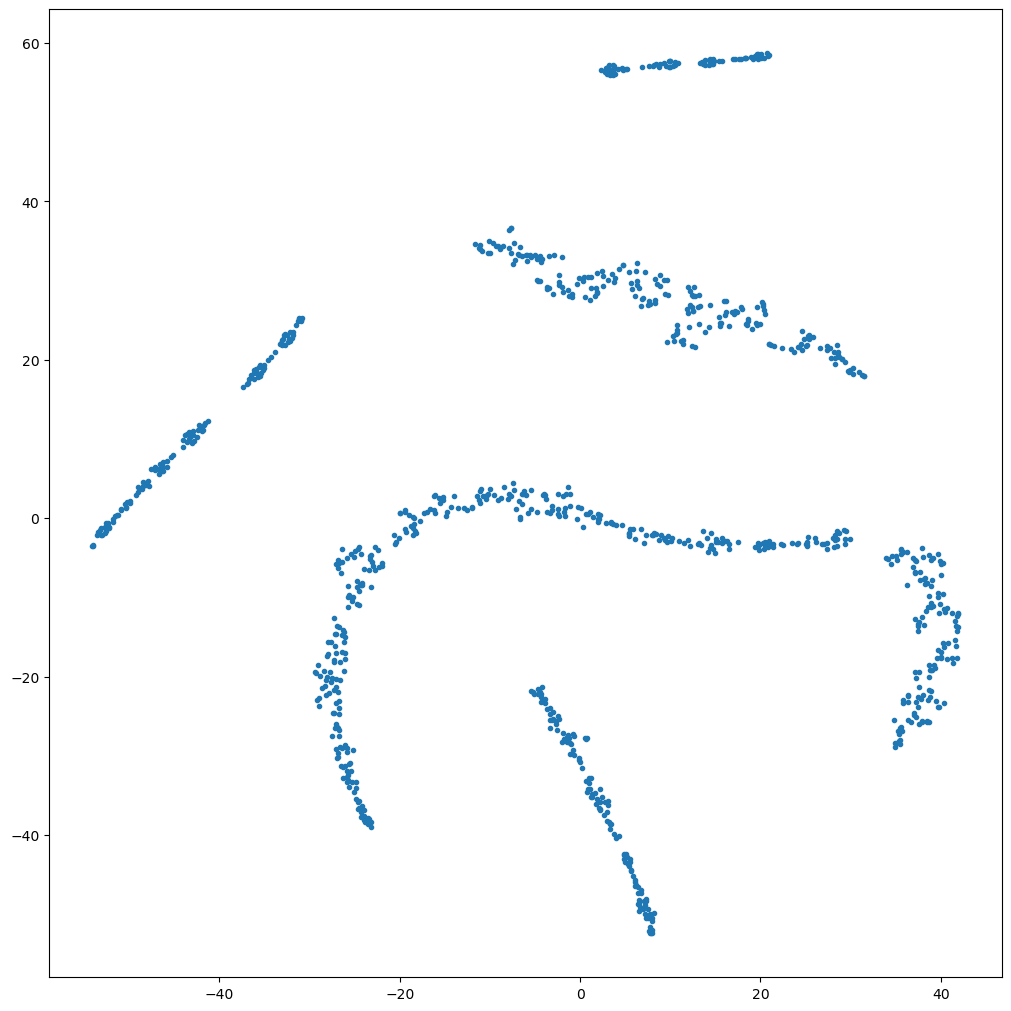

In [68]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10), facecolor="white", constrained_layout=True)
plt.scatter(X1_tsfresh_t_sne[:,0], X1_tsfresh_t_sne[:,1], marker='.')

### Optional methods

In [38]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filter_conditions([])

# exclude some groups by IDs
cont_dataset.filter_groups([])

# exclude some subjects
cont_dataset.filter_subjects([0,1, 52])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
# cont_dataset.filter_min(min_trials = 7)

# To remove subjects who do not have
# trials in all the conditions
# cont_dataset.filter_if_not_in_all_cond()


### Plot the photometry by condition

cond_ID: 0, group_idx 0, subj 280
cond_ID: 0, group_idx 0, subj 282
cond_ID: 0, group_idx 0, subj 289
cond_ID: 0, group_idx 0, subj 290
cond_ID: 0, group_idx 0, subj 291
cond_ID: 0, group_idx 0, subj 292
cond_ID: 0, group_idx 0, subj 293
cond_ID: 0, group_idx 0, subj 294
cond_ID: 0, group_idx 0, subj 295
cond_ID: 0, group_idx 0, subj 296
cond_ID: 0, group_idx 0, subj 297
cond_ID: 0, group_idx 0, subj 299
cond_ID: 0, group_idx 0, subj 300
cond_ID: 0, group_idx 0, subj 301
cond_ID: 0, group_idx 0, subj 303
cond_ID: 0, group_idx 0, subj 304
cond_ID: 0, group_idx 0, subj 305
cond_ID: 0, group_idx 0, subj 306
cond_ID: 0, group_idx 0, subj 307
cond_ID: 1, group_idx 0, subj 280
cond_ID: 1, group_idx 0, subj 282
cond_ID: 1, group_idx 0, subj 289
cond_ID: 1, group_idx 0, subj 290
cond_ID: 1, group_idx 0, subj 291
cond_ID: 1, group_idx 0, subj 292
cond_ID: 1, group_idx 0, subj 293
cond_ID: 1, group_idx 0, subj 294
cond_ID: 1, group_idx 0, subj 295
cond_ID: 1, group_idx 0, subj 296
cond_ID: 1, gr

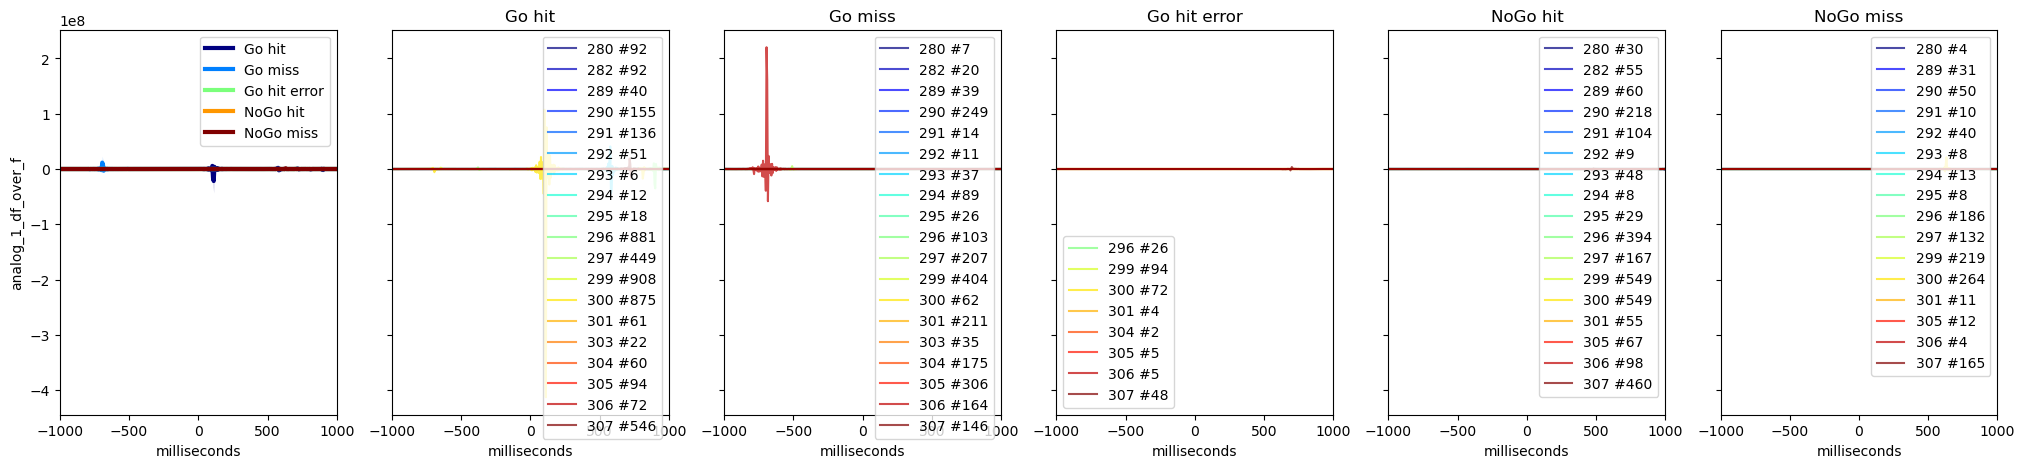

True    11188
Name: keep, dtype: int64

In [22]:
# if this was not set at creation
cont_dataset.set_trial_window([-2, 6], 's')

cont_dataset.lineplot(
    vars = ['analog_1_df_over_f'],
    time_lim = [-1000, 1000],
    time_unit = 'milliseconds',
    ylim =  None,# [[-0.004, 0.006]],#[[-0.03, 0.1]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    error = True,
    colormap = 'jet',
    legend = True,
    plot_subjects = True,
    plot_groups = True,
    figsize = (25, 5),
    dpi = 100,
    verbose = True)

# Return a count of overall number of trials
cont_dataset.metadata_df['keep'].value_counts()



In [87]:
cont_dataset.get_groups()

array([array([280, 282, 289, 290, 291, 292, 293, 294, 295, 296, 297, 299, 300,
              301, 303, 304, 305, 306, 307], dtype=int64)                     ],
      dtype=object)

### Optional methods

In [303]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filter_conditions([])

# exclude some groups by IDs
cont_dataset.filter_groups([])

# exclude some subjects
cont_dataset.filter_subjects([])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
cont_dataset.filter_min(min_trials = 1)

# To remove subjects who do not have
# trials in all the conditions
cont_dataset.filter_if_not_in_all_cond()


 conditions Int64Index([0, 1, 2, 3], dtype='int64', name='condition_ID') groups Int64Index([0], dtype='int64', name='group_ID')


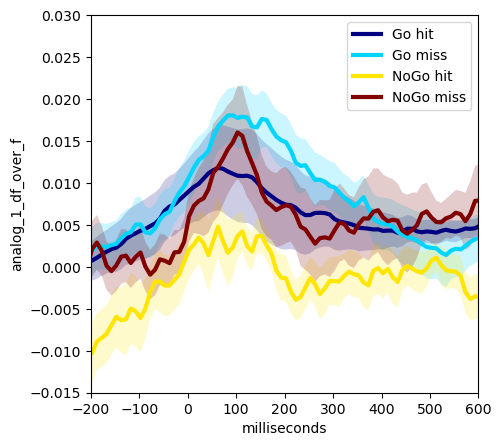

In [304]:
### Plot the photometry by condition
cont_dataset.set_trial_window([-2, 6], 's')

cont_dataset.lineplot(
    vars = ['analog_1_df_over_f'],
    time_lim = [-200, 600],
    time_unit = 'milliseconds',
    ylim = [[-0.015, 0.03]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    colormap = 'jet',
    legend = True,
    plot_subjects = False,
    plot_groups = True,
    figsize = (5, 5),
    dpi = 100,
    verbose = False)


In [305]:
dataset_full_path = r'C:\Users\phar0732\Documents\GitHub\pycontrol_share\outputs\photo_go_nogo_mf15_lp30_bar_off.pkl'
cont_dataset = load_dataset(dataset_full_path)

### Optional methods

In [306]:
# Get a list of the groups
cont_dataset.get_groups()
# Get a list of the variables
cont_dataset.get_col_names()

# reset previous filtering of the dataset
cont_dataset.filter_reset()

# exclude some conditions by IDs
cont_dataset.filter_conditions([])

# exclude some groups by IDs
cont_dataset.filter_groups([])

# exclude some subjects
cont_dataset.filter_subjects([])
#     subjects_IDs_to_exclude = [289, 290, 293, 294, 295, 299, 301, 303, 304, 305, 306])

# filter subjects/sessions with less than x trials (by condition)
cont_dataset.filter_min(min_trials = 1)

# To remove subjects who do not have
# trials in all the conditions
cont_dataset.filter_if_not_in_all_cond()


 conditions Int64Index([0, 1, 2, 3], dtype='int64', name='condition_ID') groups Int64Index([0], dtype='int64', name='group_ID')


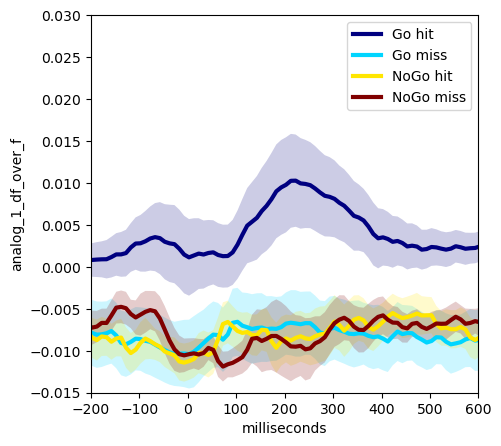

In [307]:
### Plot the photometry by condition
cont_dataset.set_trial_window([-2, 6], 's')

cont_dataset.lineplot(
    vars = ['analog_1_df_over_f'],
    time_lim = [-200, 600],
    time_unit = 'milliseconds',
    ylim = [[-0.015, 0.03]],#,[-0.005, 0.007]],#[[-0.001, 0.0011],[-0.001, 0.0011]],
    colormap = 'jet',
    legend = True,
    plot_subjects = False,
    plot_groups = True,
    figsize = (5, 5),
    dpi = 100,
    verbose = False)
